# Calculating features

In [1]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

import numpy as np
import pandas as pd
from os.path import join
import os

Using TensorFlow backend.


In [2]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [3]:
region = 'mixco_3'
train_dir = join('..', '..', 'data', region, 'roofs_train')
test_dir = join('..', '..', 'data', region, 'roofs_test')
materials = {'healthy_metal':0, 'irregular_metal':1, 'concrete_cement':2, 'incomplete':3, 'other':4}

Use a pretrained network to compute features from the images, which are later classified. Import the model from the Kerase library and remove the top layer by setting `include_top=False`. The last layer is pooled such that we get outputs of size 1x2048 instead of 7x7x2048. The pooling method `'max'` is chosen empirically.

In [4]:
model = ResNet50(weights='imagenet', include_top=False, pooling='max')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

## 1. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [5]:
def calculate_features_train(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features', 'label']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0]
                print(id, "labeled as", material, ":", label)

                # Pad if size is too small, preprocess
                img = image.load_img(img_fp, target_size=(224, 224))
                img_data = image.img_to_array(img)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Compute features 
                resnet50_feature = model.predict(img_data)
                resnet50_feature_np = np.array(resnet50_feature).flatten()

                df_features = df_features.append({'id': id ,
                                                  'features': resnet50_feature_np,
                                                  'label': label}, ignore_index=True)
    
    return df_features

The results are stored in a dataframe as shown below and saved to disk as a pickle file.

In [6]:
features_train = calculate_features_train(train_dir)

7a1ea402 labeled as healthy_metal : 0
7a1ec590 labeled as healthy_metal : 0
7a1f387c labeled as healthy_metal : 0
7a1f5d2a labeled as healthy_metal : 0
7a1fb914 labeled as healthy_metal : 0
7a206832 labeled as healthy_metal : 0
7a2176f0 labeled as healthy_metal : 0
7a2246c0 labeled as healthy_metal : 0
7a237ca2 labeled as healthy_metal : 0
7a239db8 labeled as healthy_metal : 0
7a243732 labeled as healthy_metal : 0
7a24afdc labeled as healthy_metal : 0
7a268d34 labeled as healthy_metal : 0
7a270836 labeled as healthy_metal : 0
7a272bb8 labeled as healthy_metal : 0
7a285844 labeled as healthy_metal : 0
7a287d4c labeled as healthy_metal : 0
7a297b48 labeled as healthy_metal : 0
7a2af284 labeled as healthy_metal : 0
7a2af87e labeled as healthy_metal : 0
7a2b3ef6 labeled as healthy_metal : 0
7a2c1b5a labeled as healthy_metal : 0
7a2dc716 labeled as healthy_metal : 0
7a30360e labeled as healthy_metal : 0
7a309fa4 labeled as healthy_metal : 0
7a30f152 labeled as healthy_metal : 0
7a312352 lab

C:\Users\Johannes\Miniconda3\envs\ipeo\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (98566547 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


7a39fa0e labeled as concrete_cement : 2
7a3acde4 labeled as concrete_cement : 2
7a3afb66 labeled as concrete_cement : 2
7a3b6114 labeled as concrete_cement : 2
7a3c36d4 labeled as concrete_cement : 2
7a3ce462 labeled as concrete_cement : 2
7a3cf704 labeled as concrete_cement : 2
7a3e050e labeled as concrete_cement : 2
7a3ecf2a labeled as concrete_cement : 2
7a401772 labeled as concrete_cement : 2
7a4078ac labeled as concrete_cement : 2
7a40a0ac labeled as concrete_cement : 2
7a4204d8 labeled as concrete_cement : 2
7a4226a2 labeled as concrete_cement : 2
7a42dbb0 labeled as concrete_cement : 2
7a433844 labeled as concrete_cement : 2
7a43b634 labeled as concrete_cement : 2
7a4410ac labeled as concrete_cement : 2
7a44445a labeled as concrete_cement : 2
7a1d3126 labeled as other : 4
7a1e85d0 labeled as other : 4
7a25ae32 labeled as other : 4
7a2e54e2 labeled as other : 4
7a2f1224 labeled as other : 4
7a30a7a6 labeled as other : 4
7a32d5bc labeled as other : 4
7a367d2a labeled as other : 4


In [7]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_features_' + region + '_train.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
%matplotlib inline

In [9]:
def plot_tSNE(features, labels=None, number_of_materials=5):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)
    
    # Plot D-Vectors
    plt.figure()
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)

Convert features within the dataframe to a single matrix

In [13]:
feat_matrix = features_train['features'].to_numpy()
feat_matrix = np.column_stack(feat_matrix).transpose()

labels = features_train['label'].to_numpy()

(159, 2)


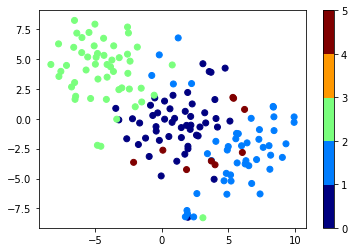

In [14]:
plot_tSNE(feat_matrix, labels)

## 2. Calculate features on the test data


This procedure is similar as for the training data, except that we do not know the labels and the folder with test images is not subdivided by material

In [15]:
def calculate_features_test(test_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            img_fp = join(root, file)
            id = file.split('.')[0]
            print("Predict features for", id)

            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            # Compute features 
            resnet50_feature = model.predict(img_data)
            resnet50_feature_np = np.array(resnet50_feature).flatten()

            df_features = df_features.append({'id': id ,
                                              'features': resnet50_feature_np},
                                             ignore_index=True)

    return df_features

In [16]:
features_test = calculate_features_test(test_dir)

Predict features for 7a452fc8
Predict features for 7a45979c
Predict features for 7a45d3d8
Predict features for 7a460e0c
Predict features for 7a464778
Predict features for 7a46bafa
Predict features for 7a46fdda
Predict features for 7a476b62
Predict features for 7a477814
Predict features for 7a47b4c8
Predict features for 7a48168e
Predict features for 7a48176a
Predict features for 7a482200
Predict features for 7a482b2e
Predict features for 7a4854c8
Predict features for 7a487a7a
Predict features for 7a48cb06
Predict features for 7a496dd6
Predict features for 7a498474
Predict features for 7a49c394
Predict features for 7a4a084a
Predict features for 7a4a0ba6
Predict features for 7a4a2d5c
Predict features for 7a4a3054
Predict features for 7a4aa5e8
Predict features for 7a4ac24e
Predict features for 7a4accbc
Predict features for 7a4ae508
Predict features for 7a4b2e0a
Predict features for 7a4b3bb6
Predict features for 7a4b6a82
Predict features for 7a4be20a
Predict features for 7a4c0eec
Predict fe

In [17]:
features_test.head()

,id,features
0,7a452fc8,"[2.4373393, 3.3714886, 0.60633343, 0.0, 0.1369..."
1,7a45979c,"[3.8263667, 9.827016, 1.9618363, 1.1913984, 0...."
2,7a45d3d8,"[0.39129314, 9.093108, 3.780588, 2.0638595, 0...."
3,7a460e0c,"[1.0500221, 4.546381, 2.4636168, 2.9973257, 1...."
4,7a464778,"[0.80244255, 24.957066, 2.509407, 0.0, 1.23971..."


In [18]:
with open(join(pickle_path, 'resnet50_features_' + region + '_test.pkl' ), 'wb') as f:
    pickle.dump(features_test, f)